# Join data

In [5]:
import pandas as pd
merged_df = pd.read_csv("outputFiles/features/elevation_weather_joined.csv")

print(merged_df.head())

   Kod_stacji   Nazwa_stacji  Miesiac  Absolutna_temperatura_maksymalna  \
0   349190600  BIELSKO-BIALA        1                              18.0   
1   349190600  BIELSKO-BIALA        2                              11.1   
2   349190600  BIELSKO-BIALA        3                              18.6   
3   349190600  BIELSKO-BIALA        4                              20.9   
4   349190600  BIELSKO-BIALA        5                              23.9   

   Srednia_temperatura_maksymalna  Absolutna_temperatura_minimalna  \
0                             5.3                             -6.2   
1                             4.6                            -14.1   
2                            10.1                             -9.1   
3                            11.7                             -6.0   
4                            17.3                              0.6   

   Srednia_temperatura_minimalna  Srednia_temperatura_miesieczna  \
0                            1.0                            

# Korelacja

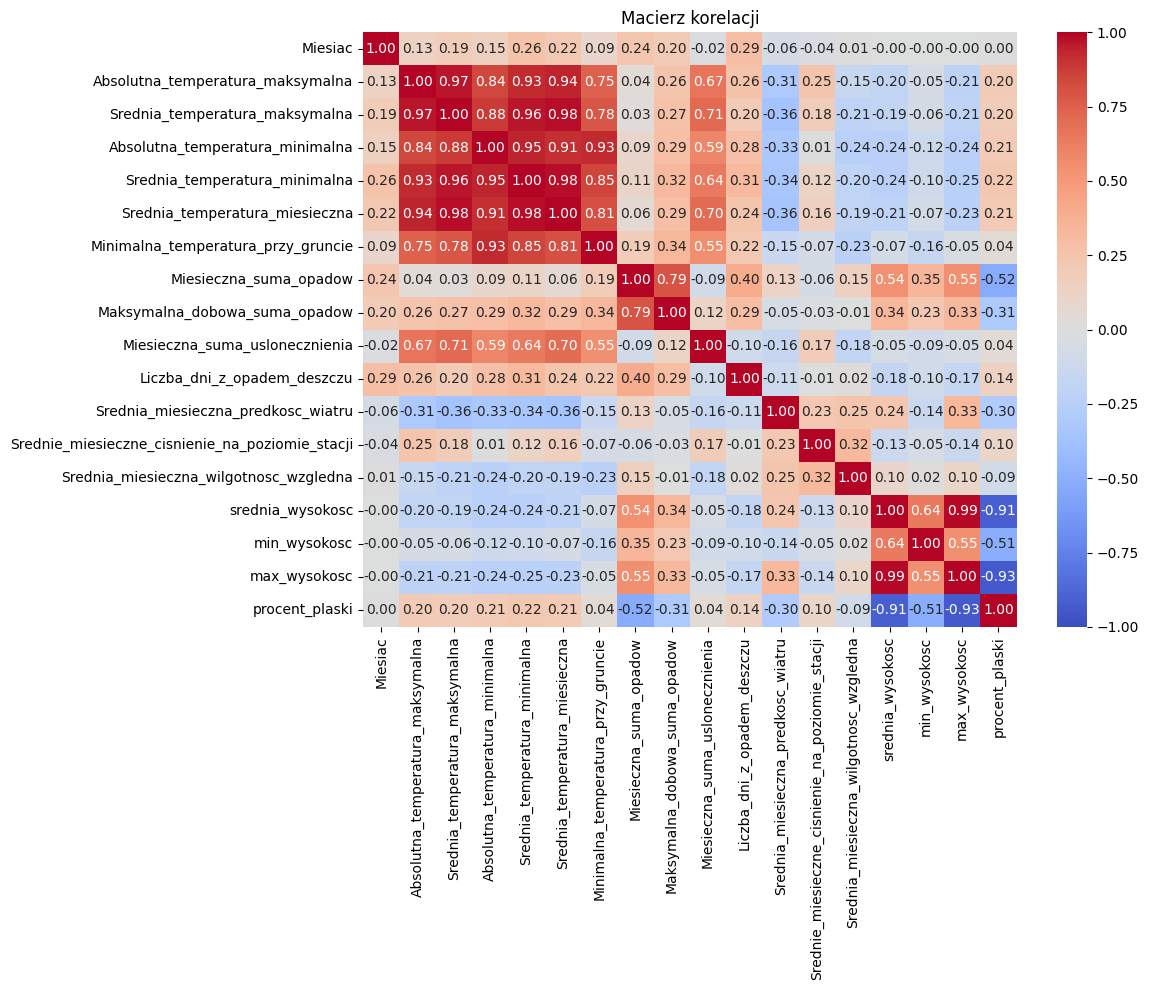

In [6]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

numeric_data = merged_df.copy().drop(columns=['Kod_stacji', 'Nazwa_stacji'])

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Macierz korelacji")
plt.tight_layout()
plt.savefig(os.path.join('outputFiles/plots', f"correlation_matrix_joined.png"))
plt.show()

# Klasteryzacja - 12 rekordów per stacja

In [7]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# merged_df = merged_df[merged_df['Miesiac'] == 4]
num_cols = merged_df.select_dtypes(include='number').columns
X = merged_df[num_cols].dropna()
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DBSCAN

Best DBSCAN params: {'eps': 3.7999999999999994, 'min_samples': 10}, Silhouette Score: 0.40905062319163343


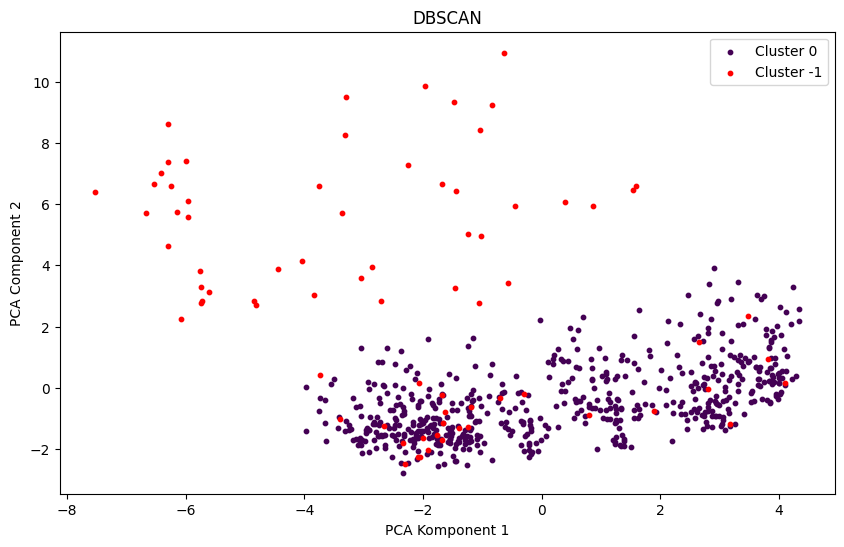

In [8]:
eps_values = np.arange(0.5, 4, 0.1)
min_samples_values = [3, 5, 7, 10]
best_dbscan_score = -1
best_dbscan_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        if len(set(dbscan_labels)) > 1:
            score = silhouette_score(X_scaled, dbscan_labels)
            if score > best_dbscan_score:
                best_dbscan_score = score
                best_dbscan_params = {"eps": eps, "min_samples": min_samples}

print(f"Best DBSCAN params: {best_dbscan_params}, Silhouette Score: {best_dbscan_score}")
dbscan = DBSCAN(**best_dbscan_params)
dbscan_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
unique_labels_dbscan = set(dbscan_labels)
colors = [plt.cm.viridis(each) for each in np.linspace(0, 1, len(unique_labels_dbscan))]
for label, color in zip(unique_labels_dbscan, colors):
    if label == -1:  # Szum
        color = [1, 0, 0, 1]
    mask = dbscan_labels == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=color, label=f"Cluster {label}", s=10)
plt.title('DBSCAN')
plt.xlabel('PCA Komponent 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


# K-MEANS

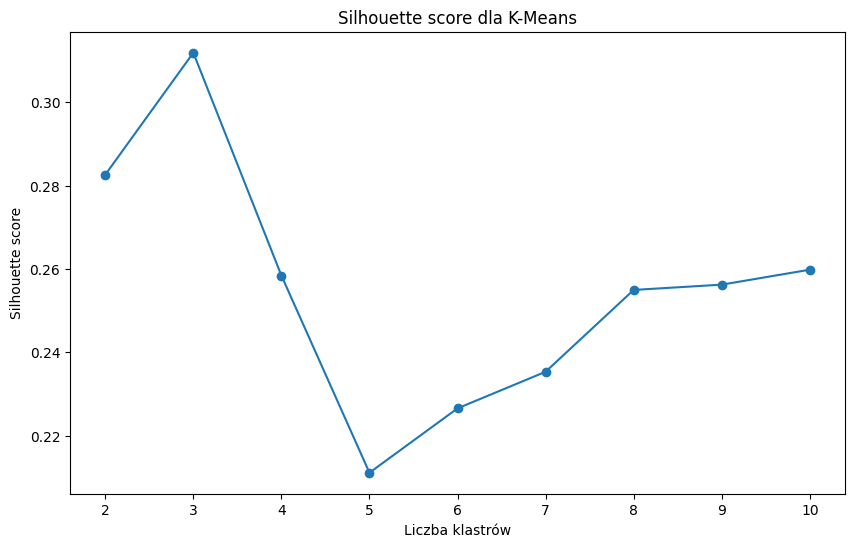

Optimal number of clusters for K-Means: 3


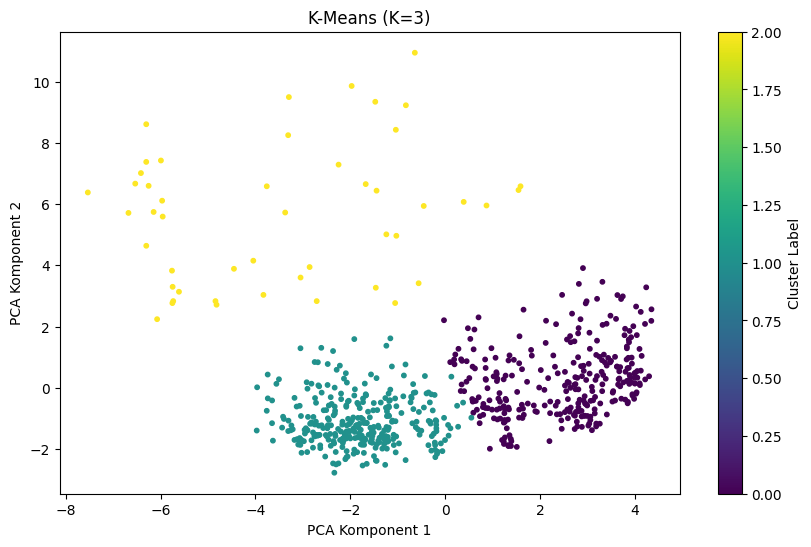

In [9]:
range_clusters = range(2, 11)
silhouette_scores_kmeans = []

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, kmeans_labels)
    silhouette_scores_kmeans.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range_clusters, silhouette_scores_kmeans, marker='o')
plt.title('Silhouette score dla K-Means')
plt.xlabel('Liczba klastrów')
plt.ylabel('Silhouette score')
plt.show()

optimal_clusters = range_clusters[np.argmax(silhouette_scores_kmeans)]
print(f"Optimal number of clusters for K-Means: {optimal_clusters}")

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title(f'K-Means (K={optimal_clusters})')
plt.xlabel('PCA Komponent 1')
plt.ylabel('PCA Komponent 2')
plt.colorbar(label='Cluster Label')
plt.show()


# HIERARCHICAL CLUSTERING

Hierarchical clutstering score: 0.28391791834348395


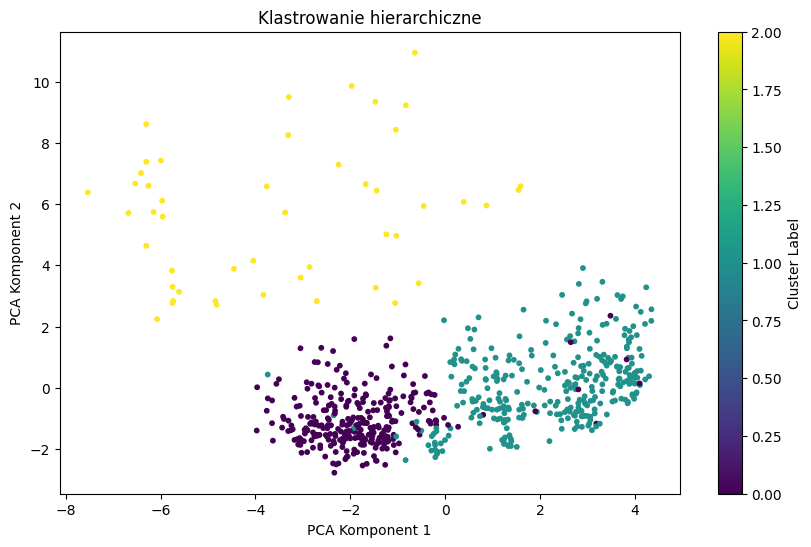

In [10]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters)
hierarchical_labels = hierarchical.fit_predict(X_scaled)
score_h = silhouette_score(X_scaled, hierarchical_labels)

print(f'Hierarchical clutstering score: {score_h}')

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='viridis', s=10)
plt.title('Klastrowanie hierarchiczne')
plt.xlabel('PCA Komponent 1')
plt.ylabel('PCA Komponent 2')
plt.colorbar(label='Cluster Label')
plt.show()

# GMM

Hierarchical clutstering score: 0.2701683771598489


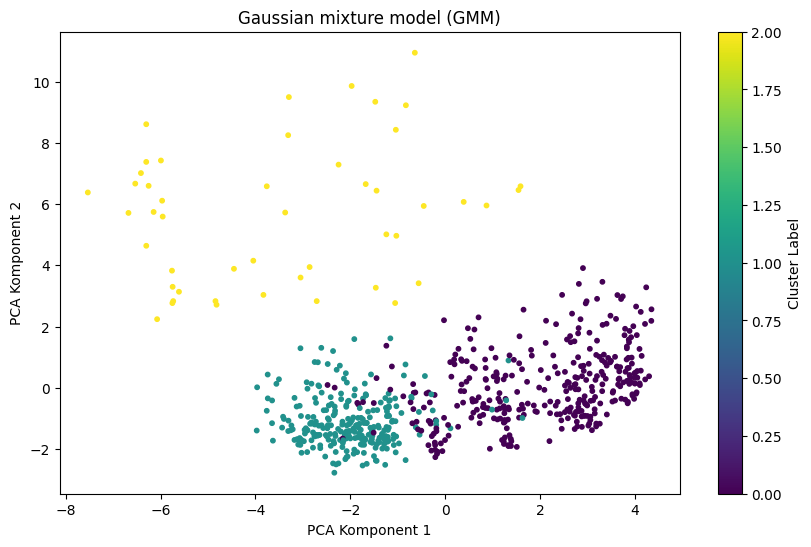

In [11]:
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

score_gmm = silhouette_score(X_scaled, gmm_labels)

print(f'Hierarchical clutstering score: {score_gmm}')

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title('Gaussian mixture model (GMM)')
plt.xlabel('PCA Komponent 1')
plt.ylabel('PCA Komponent 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Clustering - spring, summer, autumn, winter - silhouette score

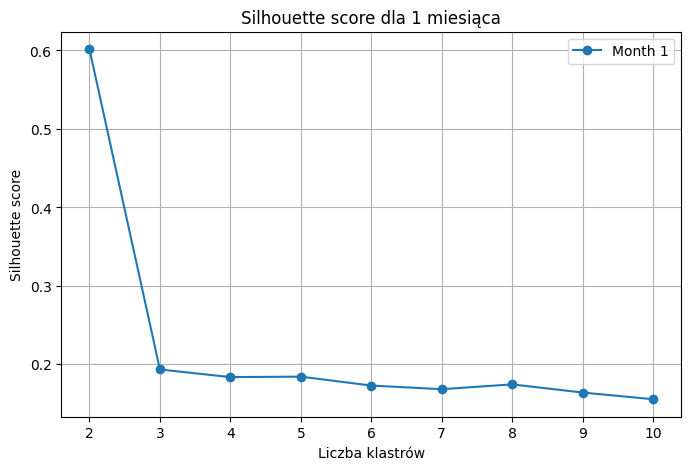

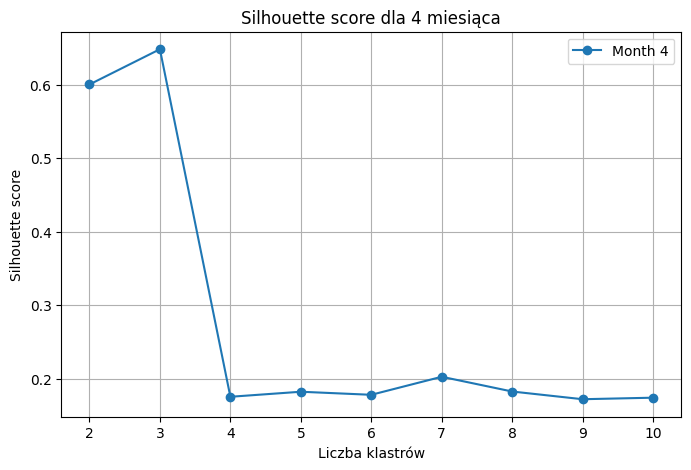

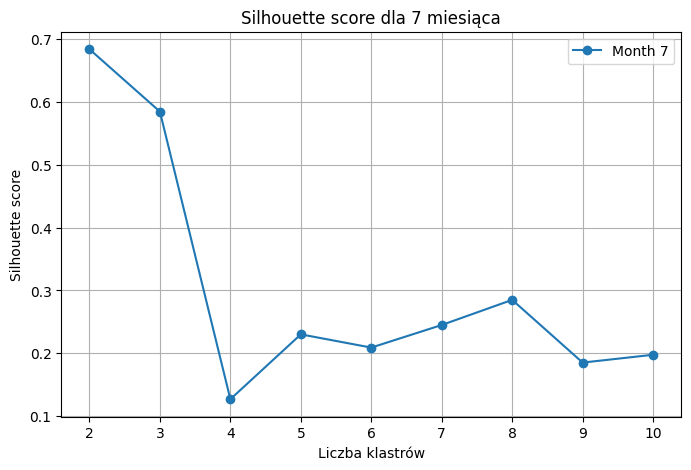

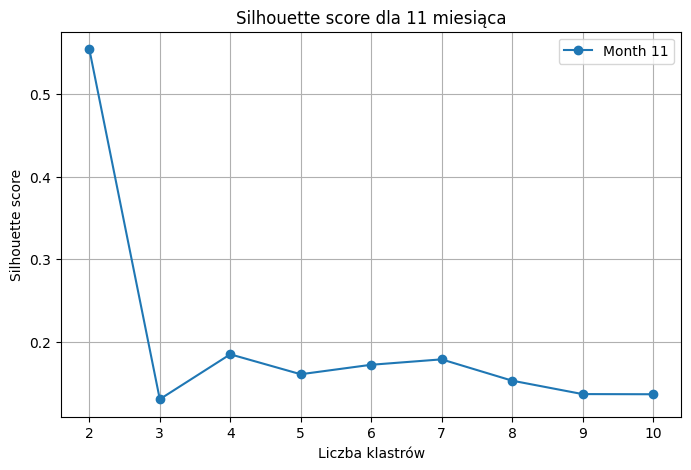

In [12]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

selected_months = [1, 4, 7, 11]
range_clusters = range(2, 11)

silhouette_scores = {month: [] for month in selected_months}

for month in selected_months:
    data_month = merged_df[merged_df['Miesiac'] == month]
    
    num_cols = data_month.select_dtypes(include='number').columns
    X = data_month[num_cols]
    
    X = X.fillna(X.mean())
    
    X_scaled = StandardScaler().fit_transform(X)
    
    for k in range_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores[month].append(score)

for month in selected_months:
    plt.figure(figsize=(8, 5))
    plt.plot(range_clusters, silhouette_scores[month], marker='o', label=f'Month {month}')
    plt.title(f'Silhouette score dla {month} miesiąca')
    plt.xlabel('Liczba klastrów')
    plt.ylabel('Silhouette score')
    plt.xticks(range_clusters)
    plt.grid(True)
    plt.legend()
    plt.show()


# Clustering - spring, summer, autumn, winter

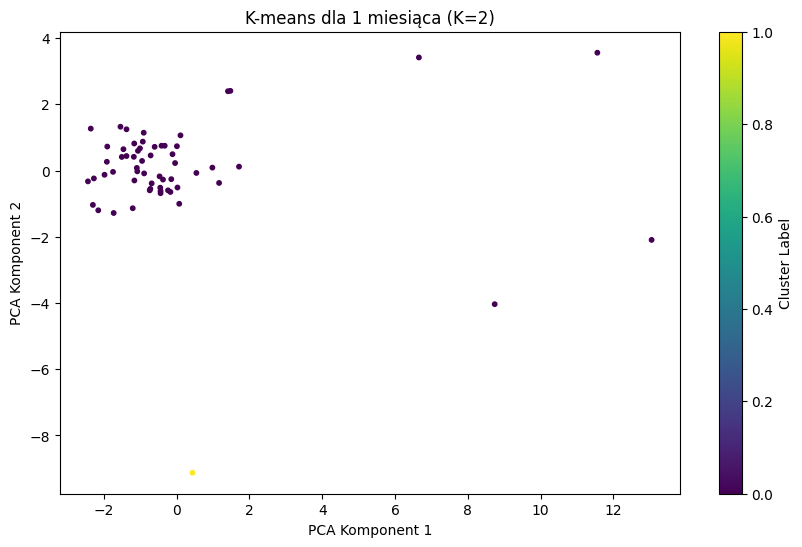

Cluster distribution for Month 1:
0    58
1     1
Name: count, dtype: int64


AttributeError: 'numpy.ndarray' object has no attribute 'isin'

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

selected_months = [1, 4, 7, 11]
cluster_results = {}
outlier_results = {}

for month in selected_months:
    # Wybór danych dla danego miesiąca
    data_month = merged_df[merged_df['Miesiac'] == month]
    
    # Przygotowanie danych
    num_cols = data_month.select_dtypes(include='number').columns
    X = data_month[num_cols]
    X = X.fillna(X.mean())  # Wypełnianie braków średnimi wartościami
    X_scaled = StandardScaler().fit_transform(X)
    
    # Ustawienie liczby klastrów
    k = 3 if month in (4, 7) else 2
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    # Redukcja wymiarów dla wizualizacji
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Wizualizacja klasteryzacji
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
    plt.title(f'K-means dla {month} miesiąca (K={k})')
    plt.xlabel('PCA Komponent 1')
    plt.ylabel('PCA Komponent 2')
    plt.colorbar(label='Cluster Label')
    plt.show()
    
    # Wyświetlenie rozkładu klastrów
    cluster_counts = pd.Series(kmeans_labels).value_counts()
    print(f"Cluster distribution for Month {month}:")
    print(cluster_counts)

    # Zapis wyników klasteryzacji
    cluster_results[month] = pd.DataFrame({
        'Kod_stacji': data_month['Kod_stacji'].values,
        'Nazwa_stacji': data_month['Nazwa_stacji'].values,
        'Cluster': kmeans_labels
    })

    # Znalezienie klastrów odstających (wszystkie inne niż klaster 0)
    outlier_clusters = [label for label in set(kmeans_labels) if label != 0]
    print(f"Outlier clusters for Month {month}: {outlier_clusters}")

    # Konwersja kmeans_labels na Pandas Series do filtrowania
    kmeans_labels_series = pd.Series(kmeans_labels, index=data_month.index)
    
    # Wyodrębnienie stacji w klastrach odstających
    outlier_stations = data_month.loc[kmeans_labels_series.isin(outlier_clusters)]
    outlier_results[month] = outlier_stations[['Kod_stacji', 'Nazwa_stacji', 'Miesiac']].assign(
        Cluster=kmeans_labels_series[kmeans_labels_series.isin(outlier_clusters)]
    )

# Wyświetlenie stacji w klastrach odstających dla każdego miesiąca
for month, df in outlier_results.items():
    print(f"Outlier stations for Month {month}:")
    print(df)



# Stacje w klastrach będącymi wartościami odstającymi

# Stacje we wspólnych klastrach

In [ ]:
station_pairs_per_month = {}
for month in selected_months:
    df = cluster_results[month]
    pairs = []
    for cluster_label in df['Cluster'].unique():
        cluster_stations = df[df['Cluster'] == cluster_label]['Kod_stacji'].values
        pairs.extend([(a, b) for i, a in enumerate(cluster_stations) for b in cluster_stations[i + 1:]])
    station_pairs_per_month[month] = set(pairs)

common_station_pairs = set.intersection(*station_pairs_per_month.values())

stations_in_common_clusters = set()
for pair in common_station_pairs:
    stations_in_common_clusters.update(pair)

stations_df = pd.DataFrame({'Kod_stacji': list(stations_in_common_clusters)})
stations_with_names = stations_df.merge(merged_df[['Kod_stacji', 'Nazwa_stacji']].drop_duplicates(), on='Kod_stacji')

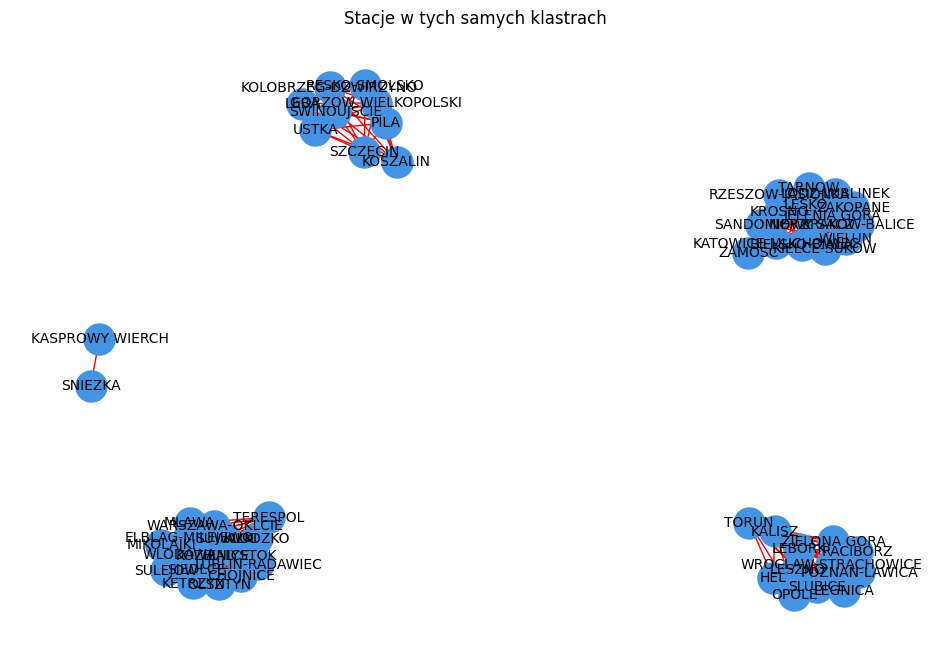

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for _, row in stations_with_names.iterrows():
    G.add_node(row['Nazwa_stacji'], label=row['Nazwa_stacji'])

for pair in common_station_pairs:
    station_a = stations_with_names.loc[stations_with_names['Kod_stacji'] == pair[0], 'Nazwa_stacji'].values[0]
    station_b = stations_with_names.loc[stations_with_names['Kod_stacji'] == pair[1], 'Nazwa_stacji'].values[0]
    G.add_edge(station_a, station_b)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.40)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="#4394E5")
nx.draw_networkx_edges(G, pos, edge_color="red")
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Stacje w tych samych klastrach")
plt.axis("off")
plt.show()


In [ ]:
from collections import defaultdict

station_groups = defaultdict(set)

for pair in common_station_pairs:
    station_groups[pair[0]].add(pair[1])
    station_groups[pair[1]].add(pair[0])

final_groups = []
visited = set()

for station in station_groups.keys():
    if station not in visited:
        group = set()
        to_visit = {station}
        
        while to_visit:
            current = to_visit.pop()
            if current not in visited:
                visited.add(current)
                group.add(current)
                to_visit.update(station_groups[current] - visited)
        
        final_groups.append(group)

final_groups_with_names = [
    {merged_df.loc[merged_df['Kod_stacji'] == station, 'Nazwa_stacji'].values[0] for station in group}
    for group in final_groups
]

for i, group in enumerate(final_groups_with_names, start=1):
    print(f"Zbiór {i}: {', '.join(group)}")


Zbiór 1: SWINOUJSCIE, PILA, SZCZECIN, USTKA, RESKO-SMOLSKO, KOLOBRZEG-DZWIRZYNO, GORZOW WIELKOPOLSKI, KOSZALIN, LEBA
Zbiór 2: OLSZTYN, ELBLAG-MILEJEWO, MIKOLAJKI, SIEDLCE, KETRZYN, KOZIENICE, CHOJNICE, MLAWA, LUBLIN-RADAWIEC, WARSZAWA-OKLCIE, BIALYSTOK, SUWALKI, KLODZKO, TERESPOL, WLODAWA, SULEJOW
Zbiór 3: LEBORK, POZNAN-LAWICA, ZIELONA GORA, WROCLAW-STRACHOWICE, HEL, TORUN, RACIBORZ, OPOLE, LESZNO, LEGNICA, SLUBICE, KALISZ
Zbiór 4: KATOWICE-MUCHOWIEC, KROSNO, LODZ-LUBLINEK, WIELUN, NOWY SACZ, KIELCE-SUKOW, TARNOW, SANDOMIERZ, LESKO, JELENIA GORA, RZESZOW-JASIONKA, ZAKOPANE, KRAKOW-BALICE, ZAMOSC, BIELSKO-BIALA
Zbiór 5: KASPROWY WIERCH, SNIEZKA
